In [ ]:
from IPython.display import YouTubeVideo, Markdown
from functools import partial
YouTubeVideo_formato = partial(YouTubeVideo, modestbranding=1, disablekb=0,
                               width=640, height=360, autoplay=0, rel=0, showinfo=0)

display(Markdown(filename='../preamble.md'))

# Exploración y manipulación de datos con [*pandas*](https://pandas.pydata.org/) <a class="tocSkip"></a>

En la clase anterior aprendimos a operar DataFrames construidos a partir de estructuras de datos de Python

> Pero el caso más general de uso de pandas es la exploración y manipulación de una base de datos tabular que podría existir como un fichero en nuestro sistema o en un servidor remoto

En este clase veremos 
- como crear DataFrames a partir de distintas fuentes de datos
- funciones más avanzadas de manipulación de DataFrames

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

display("Versión de pandas "+pd.__version__)

'Versión de pandas 1.0.3'

## Importar datos tabulares a partir de archivos CSV 

Un archivo  CSV (Comma-Separated Values) es una tabla en formato texto plano cuyas columnas están separadas por comas (u otro delimitador)

**Ejemplo**

Base de datos "Dow Jones Index" en formato CSV del [repositorio UCI](https://archive.ics.uci.edu/ml/datasets/Dow+Jones+Index)

La descargamos y observamos las 5 primeras lineas

In [5]:
%%bash
wget -c https://archive.ics.uci.edu/ml/machine-learning-databases/00312/dow_jones_index.zip
unzip -o dow_jones_index.zip
# Impri
head -5 dow_jones_index.data

Archive:  dow_jones_index.zip
  inflating: dow_jones_index.data    
  inflating: dow_jones_index.names   
quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
1,AA,1/7/2011,$15.82,$16.72,$15.78,$16.42,239655616,3.79267,,,$16.71,$15.97,-4.42849,26,0.182704
1,AA,1/14/2011,$16.71,$16.71,$15.64,$15.97,242963398,-4.42849,1.380223028,239655616,$16.19,$15.79,-2.47066,19,0.187852
1,AA,1/21/2011,$16.19,$16.38,$15.60,$15.79,138428495,-2.47066,-43.02495926,242963398,$15.87,$16.13,1.63831,12,0.189994
1,AA,1/28/2011,$15.87,$16.63,$15.82,$16.13,151379173,1.63831,9.355500109,138428495,$16.18,$17.14,5.93325,5,0.185989


--2020-06-11 17:25:56--  https://archive.ics.uci.edu/ml/machine-learning-databases/00312/dow_jones_index.zip
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



El Dow Jones es un índice bursatil muy utilizado ya que refleja el comportamiento del mercado accionario norteamericano

Podemos ver que cada fila tiene un 
- identificador textual de la acción: `AA`
- una fecha de observación: `1/7/2011`
- un precio de apertura, máximo, mínimo y cierre para la fecha: `$15.82, $16.72, $15.78, $16.42`
- entre otros

Podemos notar algunos aspectos típicos de los archivos CSV
- La primera fila del archivo CSV contiene el *header*, es decir los nombres de las columnas
- Las columnas son de tipos distintos 

¿Qué tipos puedes identificar en el ejemplo anterior?

### Función `pd.read_csv`

Para leer un archivo CSV en pandas podemos usar

```python
pd.read_csv(
    filepath_or_buffer: Union[str, pathlib.Path, IO[~AnyStr]], # path completo al archivo CSV
    sep=',', # delimitador de las columnas
    header='infer', # Puede ser un int (fila donde está el header) o una lista de de ints
    names=None, # Lista de strings con nombres de columnas (útil si el CSV no tiene header)
    index_col=None, # La columna que se usará como header
    usecols=None, # Lista: subconjunto de columnas que se desean importar (por defecto se importan todas)
    converters=None, # Se explica en detalle a continuación
    ...
    )
```


### Análisis sintático o *parsing*

Las columnas textuales de un archivo CSV pueden representar valores numéricos continuos, valores numéricos discretos, fechas, moneda, etiquetas de texto, entre muchos otros

Un *parser* o analizador sintático es un programa que analiza estos datos textuales y los convierten al formato más adecuado, por ejemplo flotante, entero, booleano o string

> Pandas hace este proceso de forma automática pero a veces esto puede no ser suficiente

Podemos proporcionar un diccionario con "reglas de parseo" adicionales con el argumento `converters` de `pd.read_csv`

El diccionario sigue la sintaxis

```python
    {'nombre de la columna 1': funcion_parseadora1, 
     'nombre de la columna 2': funcion_parseadora2,
     ...
    }
```

Donde `funcion_parseadora` puede ser una función explicita o anómina (lambda)

**Ejemplo**

Los datos de la columna de precio de apertura (open) de "dow_jones_index.data" están formateados como 

`'$15.84'`

Es decir un signo dolar seguido de un número real

Para *parsear* este valor debemos escribir una función que 
1. Elimine el signo dolar del string
1. Convierta el resto del string en flotante

Luego creamos nuestro diccionario para el argumento `converters`

```python
    def remove_dollar(text):
        # return float(x[1:]) # Elimina el primer caracter
        return float(x.strip("$")) # Elimina todos los $ del string
        
    parser = {'open': remove_dollar}
```


### Parseo de fechas

Un dato textual muy usual son las fechas

Pandas provee algunas funcionalidades para parsear fechas 

**Ejercicio:**

1. Lea el archivo `dow_jones_index.data` con `pd.read_csv` con las opciones por defecto y estudie el DataFrame resultante
1. Corrija incrementalmente:
    1. Use como índice la columna `stock`
    1. Use un conversor para todas las columnas numéricas que empiezan con `$`
    1. Use el argumento `parse_dates` para parsear la columna date como un `Timestamp` de pandas

En cada paso verifique el tipo de las columnas con el atributo `dtypes`

Con su tabla adecuadamente formateada

- Busque las filas con fechas entre el primero de Febrero y el 12 de Marzo del 2011
- 

Pandas provee la función [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) para importar tablas en formato texto plano

In [25]:
df = pd.read_csv("dow_jones_index.data")
df.head()

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,AA,1/7/2011,$15.82,$16.72,$15.78,$16.42,239655616,3.79267,NaN,NaN,$16.71,$15.97,-4.428490,26,0.182704
1,1,AA,1/14/2011,$16.71,$16.71,$15.64,$15.97,242963398,-4.42849,1.380223,239655616.0,$16.19,$15.79,-2.470660,19,0.187852
2,1,AA,1/21/2011,$16.19,$16.38,$15.60,$15.79,138428495,-2.47066,-43.024959,242963398.0,$15.87,$16.13,1.638310,12,0.189994
3,1,AA,1/28/2011,$15.87,$16.63,$15.82,$16.13,151379173,1.63831,9.355500,138428495.0,$16.18,$17.14,5.933250,5,0.185989
4,1,AA,2/4/2011,$16.18,$17.39,$16.18,$17.14,154387761,5.93325,1.987452,151379173.0,$17.33,$17.37,0.230814,97,0.175029


Algunas columnas se han guardado como strings

In [26]:
df.dtypes

quarter                                 int64
stock                                  object
date                                   object
open                                   object
high                                   object
low                                    object
close                                  object
volume                                  int64
percent_change_price                  float64
percent_change_volume_over_last_wk    float64
previous_weeks_volume                 float64
next_weeks_open                        object
next_weeks_close                       object
percent_change_next_weeks_price       float64
days_to_next_dividend                   int64
percent_return_next_dividend          float64
dtype: object

In [21]:
conv = dict.fromkeys(['open', 'close', 'high', 'low', 
                      'next_weeks_open', 'next_weeks_close'], lambda x: float(x.strip("$")))

In [22]:
df = pd.read_csv("dow_jones_index.data", sep=',', header=0, index_col='stock', 
                 converters=conv, parse_dates=[2])
df.head()

,quarter,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
stock,,,,,,,,,,,,,,,
AA,1,2011-01-07,15.82,16.72,15.78,16.42,239655616,3.79267,NaN,NaN,16.71,15.97,-4.428490,26,0.182704
AA,1,2011-01-14,16.71,16.71,15.64,15.97,242963398,-4.42849,1.380223,239655616.0,16.19,15.79,-2.470660,19,0.187852
AA,1,2011-01-21,16.19,16.38,15.60,15.79,138428495,-2.47066,-43.024959,242963398.0,15.87,16.13,1.638310,12,0.189994
AA,1,2011-01-28,15.87,16.63,15.82,16.13,151379173,1.63831,9.355500,138428495.0,16.18,17.14,5.933250,5,0.185989
AA,1,2011-02-04,16.18,17.39,16.18,17.14,154387761,5.93325,1.987452,151379173.0,17.33,17.37,0.230814,97,0.175029


Pandas fue diseñado para analizar series de tiempo e incorpora la función [`to_datetime()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html) que toma un string y retorna un `Timestamp`

Por defecto el formato se infiere, pero puede forzarce usando el argumento `format`

In [24]:
display(pd.to_datetime("1/5/2018"),
        pd.to_datetime("1st of May of 2018"),
        pd.to_datetime("May/1/2018"),
        pd.to_datetime("2018"),
        pd.to_datetime("14:45"),
        pd.to_datetime("May/1/2018 14:45"))

Timestamp('2018-01-05 00:00:00')

Timestamp('2018-05-01 00:00:00')

Timestamp('2018-05-01 00:00:00')

Timestamp('2018-01-01 00:00:00')

Timestamp('2020-06-11 14:45:00')

Timestamp('2018-05-01 14:45:00')

Para facilitarnos la vida `read_csv` tiene un argumento `parse_dates` que recibe una lista de enteros especificando las columnas que queremos convertir a fechas

Ahora que los tiempos tiene formato *timestamp* podemos usarlos como índice

Esto nos permite recuperar rapidamente todos los eventos dentro de un intervalo de tiempo

In [28]:
df = pd.read_csv("dow_jones_index.data", sep=',', header=0, index_col='date', 
                 converters=conv, parse_dates=[2])

df[df["stock"] == "AA"].loc["2011-02-01":"2011-03-12"]

,quarter,stock,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
date,,,,,,,,,,,,,,,
2011-02-04,1,AA,16.18,17.39,16.18,17.14,154387761,5.933250,1.987452,151379173.0,17.33,17.37,0.230814,97,0.175029
2011-02-11,1,AA,17.33,17.48,16.97,17.37,114691279,0.230814,-25.712195,154387761.0,17.39,17.28,-0.632547,90,0.172712
2011-02-18,1,AA,17.39,17.68,17.28,17.28,80023895,-0.632547,-30.226696,114691279.0,16.98,16.68,-1.766780,83,0.173611
2011-02-25,1,AA,16.98,17.15,15.96,16.68,132981863,-1.766780,66.177694,80023895.0,16.81,16.58,-1.368230,76,0.179856
2011-03-04,1,AA,16.81,16.94,16.13,16.58,109493077,-1.368230,-17.663150,132981863.0,16.58,16.03,-3.317250,69,0.180941
2011-03-11,1,AA,16.58,16.75,15.42,16.03,114332562,-3.317250,4.419900,109493077.0,15.95,16.11,1.003130,62,0.187149


Matplotlib tiene funciones para parsear datos temporales

<IPython.core.display.Javascript object>


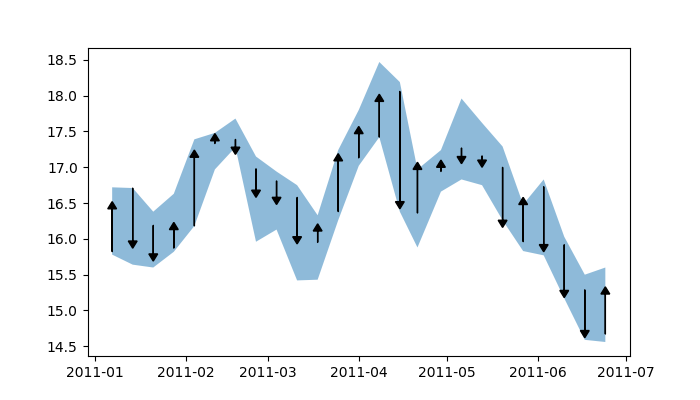

In [29]:
import matplotlib.dates as md

fig, ax = plt.subplots(figsize=(7, 4))
sub_df = df[df["stock"] == "AA"]
for x, o, c in zip(sub_df.index.values, sub_df['open'].values, sub_df['close'].values):
    ax.arrow(x=md.date2num(x), y=o, dx=0, dy=c-o, head_width=3, head_length=0.1, fc='k', ec='k')
ax.fill_between(sub_df.index.values, 
                sub_df['low'].values, sub_df['high'].values, alpha=0.5);

## Lectura de archivos excel

- Pandas provee la función [`read_excel`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html)

- Requisito adicional: [python-xlrd](https://github.com/python-excel/xlrd)

In [ ]:
!wget -c http://www.censo2017.cl/wp-content/uploads/2017/12/Cantidad-de-Viviendas-por-Tipo.xlsx

In [ ]:
df = pd.read_excel("Cantidad-de-Viviendas-por-Tipo.xlsx", sheet_name=1, 
                   usecols=list(range(1, 20)), header=1, index_col='ORDEN')

df.dropna(inplace=True)
df.drop(0, inplace=True)
display(df.head())
df.describe()

Podriamos querer obtener los valores totales de la Provincia de Valdivia: **reducción suma**

In [ ]:
col_mask = df.columns[4:-1]
display(col_mask)
row_mask = df["NOMBRE PROVINCIA"] == "VALDIVIA"
display(df.loc[row_mask].head())
df.loc[row_mask, col_mask].sum()

## Cambio de índice

Podemos usar las funciones [reset_index](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html) y [set_index](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.set_index.html#pandas.DataFrame.set_index) para modificar el índice del dataframe a nuestra conveniencia

In [ ]:
df = df.reset_index()
df = df.set_index("NOMBRE PROVINCIA")
display(df.head())
df.loc["VALDIVIA", col_mask].sum()

In [ ]:
df = df.reset_index()
df = df.set_index("ORDEN")
%timeit -n20 df.loc[df["NOMBRE PROVINCIA"] == "VALDIVIA", col_mask].sum()
df = df.reset_index()
df = df.set_index("NOMBRE PROVINCIA")
%timeit -n20 df.loc["VALDIVIA", col_mask].sum()
df = df.reset_index()
df = df.set_index("ORDEN")

## Groupby: Reducciones condicionales

En el caso anterior podemos reducir de forma separada para cada región o provincia sin cambiar índices

La función [`groupby`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) permite hacer una reducción condicional a una etiqueta

Podemos imaginar que la función `groupby` es una [secuencia](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html) como la siguiente:


Donde
- *Split*: divide los datos según una **llave**
- *Apply*: Realiza una función sobre cada grupo: reducción, transformación, filtrado
- *Combine*: Mezcla el resultado en un nuevo dataframe donde la **llave** se convierte en el índice

In [ ]:
df = pd.read_excel("Cantidad-de-Viviendas-por-Tipo.xlsx", sheet_name=1, 
                   usecols=list(range(1, 20)), header=1, index_col='ORDEN')

df.dropna(inplace=True)
df.drop(0, inplace=True)

In [ ]:
df_redu = df.groupby("NOMBRE REGIÓN").sum()
display(df_redu.head())
fig, ax = plt.subplots(figsize=(6, 7), tight_layout=True)
df_redu.plot(ax=ax, y=0, kind='bar', logy=True);

`groupby` puede usarse como iterador

In [ ]:
for (region, sub_df) in df.groupby('NOMBRE REGIÓN'):
    display(region, sub_df)

Notar que no estamos limitados a las reducciones definidas

Podemos usar los atributos de `groupby` para obtener más funcionalidad
- `aggregate` : Operación de reducción
- `filter` : Operación de eliminación de filas (drop)
- `transform` : Operación de modificación columna a columna
- `apply`: Aplica una función arbitraria 

In [ ]:
mask = df.columns[6:]
print(mask)

# Las funciones de reducción deben recibir un arreglo y retornar un valor
def mi_reduccion(x):
    N = len(x)
    return np.sqrt(np.sum((x - np.mean(x))**2)/(N-1))

# Argumento lista de funciones: Cada función se aplica a todas las columnas
display(df.groupby("NOMBRE REGIÓN")[mask].aggregate([mi_reduccion, np.std]).head())
# Argumento diccionario de funciones: una función distinta por columna
display(df.groupby("NOMBRE REGIÓN").aggregate({mask[0]: np.std, 
                                               mask[1]: mi_reduccion}).head())

In [ ]:
display(mask[0], mask[-1])

def mi_filtro(x):
    #Regiones donde en promedio las comunas tengan una proporcion de viviendas ocupadas(presentes)/total mayor a 85%
    return np.mean(x[mask[0]]/x[mask[-1]]) > 0.8
    # Regiones donde la proporción de viviendas ocupadas(presentes) / total sea mayor a 85%
    #return np.sum(x[mask[0]])/np.sum(x[mask[-1]]) > 0.8

# El filtro debe establecer una condición sobre el grupo completo
# En este caso retorna df menos las comunas de las regiones con menos de 500.000 viviendas

sub_df = df.groupby("NOMBRE REGIÓN").filter(mi_filtro)
display(sub_df["NOMBRE REGIÓN"].unique(),
        sub_df)

In [ ]:
def mi_transformación(x):
    if x.dtype == np.float:
        return (x - x.mean())/x.std()
    else:
        return x 
    
def mi_transformación2(x):
    return (x - x.mean())/x.std()

# La transformación opera columna por columna
# La transformación debe retornar un resultado que es del mismo tamaño de la entrada

display(df.groupby("NOMBRE REGIÓN").transform(mi_transformación), 
        df.groupby("NOMBRE REGIÓN")[mask].transform(mi_transformación2))

In [ ]:
def mi_funcion(x):
    col = 'Viviendas Particulares Ocupadas con Moradores Presentes'
    x[col] -= x[col].mean()
    return x


df.groupby("NOMBRE REGIÓN").apply(mi_funcion)

## Splitting

Podemos usar más de una etiqueta para hacer el splitting de `groupby`

Podemos también usar una función, una lista, diccionario o dataframe

Refierase a la [documentación](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html) para más detalles

In [ ]:
df.groupby(["NOMBRE REGIÓN", "NOMBRE PROVINCIA"]).sum()

## Multi índices

Hemos notado que la tabla tiene estructura jerárquica: REGION, PROVINCIA, COMUNA

Podemos usar un multi-índice en pandas para manipular mejor esta tabla

Podemos crear un multi-índice usando la modulo `MultiIndex` y sus funciones `from_array`, `from_frame` y `from_tuple`

Luego podemos aplicarlo con la función `set_index`

In [ ]:
# Set_index acepta una lista con nombres de columna:
df.reset_index()
df = df.set_index(["NOMBRE REGIÓN", "NOMBRE PROVINCIA"])
df.head(10)

In [ ]:
display(df.index)

Indexando y haciendo slicing con dataframes multi-indexados

Usamos una tupla para especificar los índices primario y secundario

Se usa el objeto [`IndexSlice`](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.IndexSlice.html) para generar slices

In [ ]:
idx = pd.IndexSlice

display(df.loc["LOS RÍOS"],
        df.loc[("LOS LAGOS", "OSORNO")],
        df.loc[idx[:, "VALDIVIA"], :],
        df.loc[("LOS RÍOS", "RANCO"), "Viviendas Particulares Ocupadas con Moradores Presentes":])

## Pivoting

In [ ]:
df.stack()

## La función `eval` y la función `query` 

[`eval`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.eval.html) y [`query`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html) son atributos de DataFrame que permiten evaluar una expresión arbitraria o hacer consultas (filtro) sobre las columnas del dataframe, respectivamente

Están basadas en [`numexpr`](https://github.com/pydata/numexpr) que es un evaluador de expresiones numéricas acelerado para ndarray (rendimiento casi C)

`numexpr` acepta un string con una expresión estilo numpy, la evalua y returna el resultado

Si los arreglos son grandes ganamos en velocidad y en memoria

In [ ]:
import numexpr as ne

A = np.arange(100000).reshape(1000, 100)

# NumPy es más lento ya que evalua y guarda cada paso
%timeit -n10 np.tanh(-A**2) > np.exp(np.cos(A)/2)
%timeit -n10 ne.evaluate("tanh(-A**2) > exp(cos(A)/2)")

b1 = np.tanh(-A**2) > np.exp(np.cos(A)/2)
b2 = ne.evaluate("tanh(-A**2) > exp(cos(A)/2)")
np.allclose(b1, b2)

**OJO:** Nuestras columnas no pueden tener espacios en sus nombres para poder usar `query`/`eval`

### Renombrando las columnas

Podemos 

- Usar el atributo `rename` y especificar los nuevos nombres uno a uno 
- Aplicar operaciones de string al atributo `columns`

In [ ]:
df = pd.read_excel("Cantidad-de-Viviendas-por-Tipo.xlsx", sheet_name=1, 
                   usecols=list(range(1, 20)), header=1, index_col='ORDEN')
df.dropna(inplace=True)
df.drop(0, inplace=True)
# df.rename(columns={'NOMBRE PROVINCIA': 'NOMBRE_PROVINCIA'}, inplace=True)
df.columns = df.columns.str.replace(' ', '_')

### Uso de eval y query

Hacemos operaciones o consultas sobre las columnas usando su etiqueta

Para `query` podemos juntar varias consultas con `and` y `or`

Podemos llamar variables externas anteponiendo un `@`

Al igual que con numexpr las operaciones intermedias no se guardan en memoria

- Opinión objetiva: Si el dataframe es grande ganamos en velocidad en uso de memoria
- Opinion subjetiva: En general ganamos en legibilidad

Forma tradicional versus `eval`

In [ ]:
a = df['Viviendas_Particulares_Ocupadas_con_Moradores_Presentes']/df['TOTAL_VIVIENDAS']
b = df.eval('Viviendas_Particulares_Ocupadas_con_Moradores_Presentes/TOTAL_VIVIENDAS')
np.allclose(a, b)
display(b.head())

Podemos evaluar y guardar el resultado directamente en el dataframe

In [ ]:
df.eval('Proporcion_encuestas_vs_total = Viviendas_Particulares_Ocupadas_con_Moradores_Presentes/TOTAL_VIVIENDAS', inplace=True)
df.head()

Filtrando con `query`

In [ ]:
percentage = 0.75
df.query('NOMBRE_PROVINCIA == "VALDIVIA" \
and Viviendas_Particulares_Ocupadas_con_Moradores_Presentes/TOTAL_VIVIENDAS > @percentage').head()

## Lectura de bases de datos SQL

Pandas puede usarse para leer y hacer consultas a una base de datos en formato SQL

Primero vamos a crear una base de datos e insertar un dataframe como tabla

Usaremos [sqlite3](https://docs.python.org/3/library/sqlite3.html) que es parte de la librería estándar de Python

- sqlite permite conectar a una base de datos local: RAM, disco, o disco externo montado
- sqlite no está diseñado para soportar múltiples usuarios conectados a una misma base de datos
- Alternativas: [SQL Alchemy](https://www.sqlalchemy.org/), [PostgreSQL+Python](http://initd.org/psycopg/), [Peewee](http://docs.peewee-orm.com/en/latest/)


In [ ]:
import sqlite3 
# Abrimos una conexión
conn = sqlite3.connect(":memory:")
# La palabra clave :memory: corresponde a una base de datos en memoria RAM
df.to_sql("censo_viviendas", conn, if_exists='replace', index=False)

Podemos usar [`read_sql_query()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_sql_query.html) para hacer una consulta y retornar un dataframe

Por ejemplo si queremos toda la tabla:

In [ ]:
sql_string = "SELECT * FROM censo_viviendas limit 10"
print(sql_string)
pd.read_sql_query(sql_string, conn)

O si quieremos un subconjunto específico:

In [ ]:
sql_string = "SELECT [{0}], [{1}] FROM censo_viviendas WHERE [{2}] = 'VALDIVIA' limit 5".format("Viviendas_Particulares_Ocupadas_con_Moradores_Presentes", 
                                                                                                "NOMBRE_COMUNA",
                                                                                                "NOMBRE_PROVINCIA")
print(sql_string)
pd.read_sql_query(sql_string, conn)

In [ ]:
# Cerramos la conexión a la base de datos
conn.close()

## Guardar y leer una tabla en formato JSON

Podemos usar el atributo [`to_json`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_json.html) para convertir un dataframe a este formato

El keyword `orient` nos permite seleccionar como organizar el scheme del json

Las opciones son `columns` (por defecto), `table`, `values`, `index`, `split` y `records`

In [ ]:
df.to_json("pandas.json", orient='table')

!head -c 200 pandas.json
print("")
!ls -lah pandas.json

In [ ]:
# Tenemos que usar la misma orientación con la que lo guardamos
pd.read_json("pandas.json", orient='table').head()

## Guardar y leer una tabla en formato HDF5

Podemos usar el atributo `to_hdf` para convertir nuestra tabla a formato HDF5

Para acceso de más bajo nivel podemos usar la clase `HDFStore`

Para lectura podemos usar la función `read_hdf`

OJO: Requiere Pytables mayor a 3.5: https://github.com/PyTables/PyTables/issues/719

In [ ]:
df.to_hdf("pandas_hdf.h5", key='excel', mode='w')

mi_tabla_recuperada = pd.read_hdf("pandas_hdf.h5", key='/excel', mode='r')
display(mi_tabla_recuperada)

In [ ]:
import h5py

with h5py.File("pandas_hdf.h5", mode="r") as f:
    print(f["excel"].keys())
    print(f["excel"]['block0_items'][()])